Saved visualization to visu_sets\engine\filtered_205769000_20240525_2042-20240525_2242_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_205769000_20240527_2242-20240528_0041_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209217000_20240523_1439-20240523_1639_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209217000_20240523_1639-20240523_1839_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209332000_20240528_0541-20240528_0741_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209332000_20240528_0742-20240528_0941_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209662000_20240522_1755-20240522_1955_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209662000_20240522_1955-20240522_2155_standardized_60s.png
Saved visualization to visu_sets\engine\filtered_209715000_20240526_2144-20240526_2344_standardized_60s.png
Saved visualization to visu_

KeyboardInterrupt: 

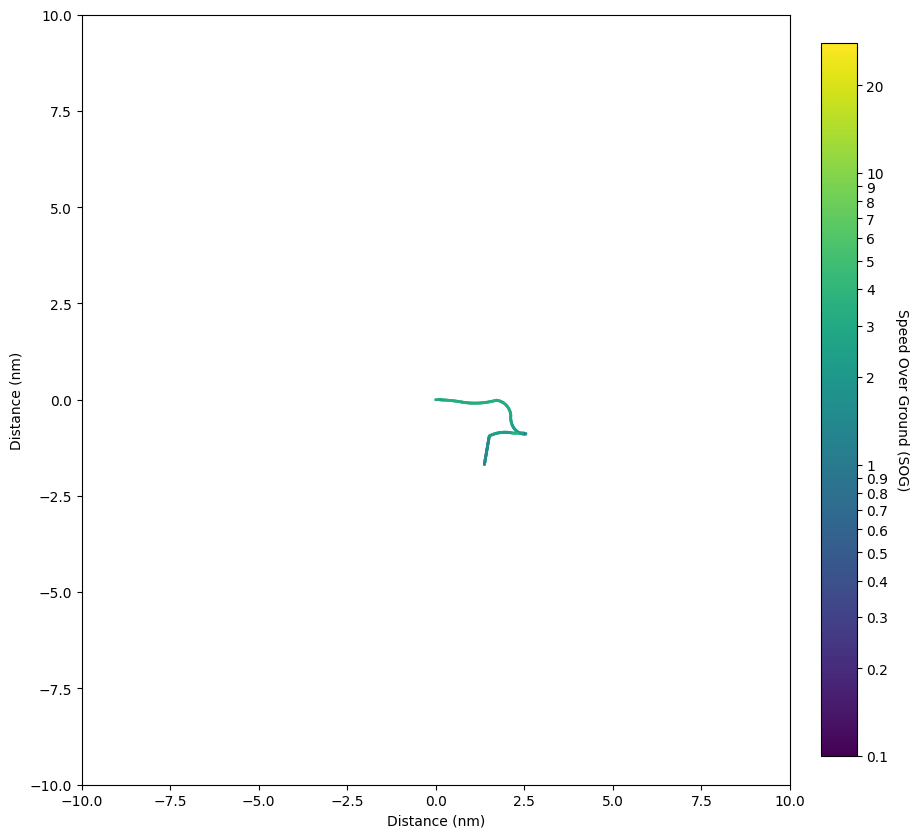

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

# Input and output folders
input_folder = "../5_Data_Pipeline/time_sets_st_shortened"
output_folder = "visu_sets"
fishing_folder = os.path.join(output_folder, "fishing")
engine_folder = os.path.join(output_folder, "engine")

# Create output folders if they don't exist
os.makedirs(fishing_folder, exist_ok=True)
os.makedirs(engine_folder, exist_ok=True)

# Get all CSV files in the input folder
all_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Calculate global min and max SOG values
global_min_sog = float('inf')
global_max_sog = float('-inf')

# First pass: Determine global SOG range
for file_name in all_files:
    file_path = os.path.join(input_folder, file_name)
    data = pd.read_csv(file_path)
    if 'SOG' in data.columns:
        global_min_sog = min(global_min_sog, data['SOG'].min())
        global_max_sog = max(global_max_sog, data['SOG'].max())

# Adjust min and max to avoid issues with log scale
global_min_sog = max(global_min_sog, 0.1)  # Avoid zero or negative values
global_max_sog = max(global_max_sog, 1.0)  # Ensure max is at least 1

# Set up the global normalization and colormap
norm = LogNorm(vmin=global_min_sog, vmax=global_max_sog)
cmap = plt.cm.viridis  # Choose your preferred colormap
sm = ScalarMappable(cmap=cmap, norm=norm)

def visualize_vessel_path(file_path, output_path, status):
    try:
        # Load the data
        data = pd.read_csv(file_path)

        # Validate required columns
        required_columns = {'Timestamp', 'SOG', 'COG', 'Navigational status'}
        if not required_columns.issubset(data.columns):
            print(f"Skipping {file_path}: Missing required columns.")
            return

        # Filter data by Navigational Status
        if status not in data['Navigational status'].iloc[0]:
            return  # Skip files that don't match the desired navigational status

        # Convert 'Timestamp' to datetime
        data['Timestamp'] = pd.to_datetime(data['Timestamp'])
        
        # Calculate time differences (in hours) between consecutive points
        data['time_diff'] = data['Timestamp'].diff().dt.total_seconds() / 3600  # Convert to hours
        data.loc[0, 'time_diff'] = 0  # Set the first time_diff to 0

        # Calculate the change in position (in nautical miles)
        data['x'] = data['SOG'] * data['time_diff'] * np.cos(np.deg2rad(data['COG']))
        data['y'] = data['SOG'] * data['time_diff'] * np.sin(np.deg2rad(data['COG']))

        # Calculate the cumulative sum of positions
        data['x_cum'] = data['x'].cumsum()
        data['y_cum'] = data['y'].cumsum()

        # Plot the path with speed color coding
        plt.figure(figsize=(10, 10))
        ax = plt.gca()  # Get the current Axes instance
        for i in range(len(data) - 1):
            plt.plot(
                [data['x_cum'].iloc[i], data['x_cum'].iloc[i + 1]],
                [data['y_cum'].iloc[i], data['y_cum'].iloc[i + 1]],
                color=cmap(norm(data['SOG'].iloc[i])),
                linewidth=2
            )

        # Add a colorbar to show speed mapping
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Speed Over Ground (SOG)', rotation=270, labelpad=15)

        # Custom ticks for the colorbar
        ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{t:g}" for t in ticks])

        # Set axis limits to the standardized size
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)

        # Label axes with units (nautical miles)
        plt.xlabel('Distance (nm)')
        plt.ylabel('Distance (nm)')

        # Save the plot with a higher resolution (dpi=300) and not transparent background
        plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=False)
        plt.close()
        print(f"Saved visualization to {output_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Process each file and save to corresponding folder
for file_name in all_files:
    input_path = os.path.join(input_folder, file_name)
    data = pd.read_csv(input_path)

    # Check if the "Navigational Status" is either "Under way using engine" or "Engaged in fishing"
    status = data['Navigational status'].iloc[0]  # Assuming it's the same for all rows in the file
    
    if status == "Under way using engine":
        output_path = os.path.join(engine_folder, file_name.replace('.csv', '.png'))
        visualize_vessel_path(input_path, output_path, status)
    elif status == "Engaged in fishing":
        output_path = os.path.join(fishing_folder, file_name.replace('.csv', '.png'))
        visualize_vessel_path(input_path, output_path, status)

print("Visualization process completed.")

In [3]:
import os
from PIL import Image

def make_white_transparent(input_path, output_path):
    """Make white pixels in an image transparent."""
    img = Image.open(input_path).convert("RGBA")
    datas = img.getdata()

    new_data = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            new_data.append((255, 255, 255, 0))  # Transparent
        else:
            new_data.append(item)

    img.putdata(new_data)
    img.save(output_path, "PNG")

def process_folders(input_folder1, input_folder2, output_folder1, output_folder2):
    """Process all images in two folders."""
    # Ensure output directories exist
    os.makedirs(output_folder1, exist_ok=True)
    os.makedirs(output_folder2, exist_ok=True)

    # Process first folder
    for file_name in os.listdir(input_folder1):
        input_path = os.path.join(input_folder1, file_name)
        output_path = os.path.join(output_folder1, file_name)
        if os.path.isfile(input_path) and input_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing: {input_path}")
            make_white_transparent(input_path, output_path)

    # Process second folder
    for file_name in os.listdir(input_folder2):
        input_path = os.path.join(input_folder2, file_name)
        output_path = os.path.join(output_folder2, file_name)
        if os.path.isfile(input_path) and input_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing: {input_path}")
            make_white_transparent(input_path, output_path)

# Example usage
input_folder1 = "./visu_sets/engine"  # Replace with your first input folder path
input_folder2 = "./visu_sets/fishing"  # Replace with your second input folder path
output_folder1 = "./visu_sets_transp/engine"  # Replace with your first output folder path
output_folder2 = "./visu_sets_transp/fishing"  # Replace with your second output folder path

process_folders(input_folder1, input_folder2, output_folder1, output_folder2)


Processing: ./visu_sets/engine\filtered_205769000_20240525_2042-20240525_2242_standardized_60s.png
Processing: ./visu_sets/engine\filtered_205769000_20240527_2242-20240528_0041_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209217000_20240523_1439-20240523_1639_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209217000_20240523_1639-20240523_1839_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209332000_20240528_0541-20240528_0741_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209332000_20240528_0742-20240528_0941_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209662000_20240522_1755-20240522_1955_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209662000_20240522_1955-20240522_2155_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209715000_20240526_2144-20240526_2344_standardized_60s.png
Processing: ./visu_sets/engine\filtered_209715000_20240530_1544-20240530_1744_standardized_60s.png
Processing